In [34]:
import pandas as pd
import re
import itertools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import igraph as ig
from IPython.display import HTML
import multiprocessing
import pickle as pkl
import random
from collections import Counter
import os
import subprocess
from scipy.stats import mannwhitneyu
import ete3
from copy import deepcopy
from math import ceil
import openpyxl

%cd /nobackup1c/users/payette/eggNOGbyClass1 #switched to nobackup1c

ncbi = ete3.NCBITaxa()
#%run assess_connections-functions.ipynb

[Errno 2] No such file or directory: '/nobackup1c/users/payette/eggNOGbyClass1 #switched to nobackup1c'
/nobackup1c/users/payette/eggNOGbyClass1


In [35]:
ABCDG_sampled_genomes = pd.read_excel('ABCDG_tree_taxa.xlsx')
ABCDG_sampled_genomes = ABCDG_sampled_genomes[ABCDG_sampled_genomes['TaxID'] != 2762020] #Exclude this taxa b/c error

In [36]:
def reconstruct_candidate(group_cluster):
    extract_cluster(group_cluster)
    
    group_id, cluster_num = group_cluster.split('#')
    
    with open('alignments/%s-cluster%s.aln' % (group_id, cluster_num), 'w') as out:
        subprocess.call(['/cm/shared/engaging/mafft/7.245-with-extensions/bin/mafft', 
                         '--auto', 
                         '--reorder', 
                         'alignments/%s-cluster%s.faa' % (group_id, cluster_num)],
                        stdout=out)
        
    subprocess.call(['/cm/shared/engaging/iqtree/1.6.3/bin/iqtree',
                     '-m', 'LG+G',
                     #'-nt', '2',
                     '-nt', 'AUTO',
                     '-s', 'alignments/%s-cluster%s.aln' % (group_id, cluster_num),
                     '-pre', 'trees/%s-cluster%s' % (group_id, cluster_num),
                     '-bb', '1000', 
                     #'-quiet',
                     '-safe'])
    
    subprocess.call(['/home/payette/.conda/envs/py37/bin/python3',
                     '/nobackup1c/users/payette/mad.py',
                     'trees/%s-cluster%s.treefile' % (group_id, cluster_num),
                     '-t'])

In [37]:
lineages = pd.DataFrame()
for taxid in ABCDG_sampled_genomes['TaxID'].unique():
    if pd.isna(taxid):
        continue
    lineages = lineages.append({tax_rank: tmp_taxid 
                                 for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()},
                                ignore_index=True)
lineages = lineages.reindex(columns=['class', 'family',  'genus', 'phylum',
                                     'order', 'species', 'superkingdom']).copy()
lineages = lineages.query('superkingdom == 2').copy()

In [38]:
#one liner to make all Proteobacteria (1224) classes into phyla
lineages.loc[lineages['phylum']==1224, 'phylum'] = lineages.loc[lineages['phylum']==1224, 'class']

In [39]:
sampled_phyla = [phylum for phylum in lineages.phylum.unique().astype(int) if phylum > 0]

In [40]:
working_groups  = pd.read_parquet('working_eggNOG_groups.parquet')
working_trees   = pd.read_parquet( 'working_eggNOG_trees.parquet')
eggNOG_taxonomy = pd.read_parquet(      'eggNOG_taxonomy.parquet')

In [41]:
with open('ABGD_all_results.pkl', 'rb') as _:   # ABCDG_proteo_all_results.pkl has different target phyla/classes
    phylum_connections = pkl.load(_)

In [42]:
regular_connections     = []
significant_connections = []

for group_id, group_clusters in phylum_connections:
    if not group_clusters:
        continue
    
    for cluster_num, cluster_data in group_clusters.items():

        for ref_phylum, phyla_dists in cluster_data.items():
            
#             if not phyla_dists['df'].shape[0]:
#                 continue

            #
            # what is the closest <phylum> to <reference phylum>
            closest_phylum = phyla_dists['df'].iloc[0, 0]
            #
            # if the closest <phylum> is not among the ones we are interested at, 
            #   ignore this one and go to the next <reference phylum>
            if not closest_phylum in sampled_phyla:
                continue

            #
            # if distance between <reference phylum> and its closest phylum is significant...
            if phyla_dists['significant']:
                
                #
                # add it to the list of potential HGTs
                significant_connections.append( 
                    (ref_phylum,
                     phyla_dists['df'].iloc[0, 0], # closest phylum's name
                     phyla_dists['df'].iloc[0, 1], # avg. distance between phyla
                     '%s#%i' % (group_id, cluster_num)) 
                )

                #
                # and the second closest phylum onwards to regular relationships
                #   a.k.a. not HGTs...
                for index, tmp_series in phyla_dists['df'].iloc[1:, :].iterrows():
                    if tmp_series.phylum in sampled_phyla:
                        regular_connections.append( (ref_phylum,
                                                     tmp_series.phylum,
                                                     tmp_series['median'], 
                                                     '%s#%i' % (group_id, cluster_num)) )

            #
            # if the distance is not significant, just add everyting to regular
            #   relationships...
            else:
                for index, tmp_series in phyla_dists['df'].iterrows():
                    if tmp_series.phylum in sampled_phyla:
                        regular_connections.append( (ref_phylum,
                                                     tmp_series.phylum,
                                                     tmp_series['median'], 
                                                     '%s#%i' % (group_id, cluster_num)) )

significant_df = pd.DataFrame(data   =significant_connections, 
                              columns=['source', 'target', 'distance', 'group'])
regular_df     = pd.DataFrame(data   =regular_connections,     
                              columns=['source', 'target', 'distance', 'group'])

significant_df.dropna(how='any', inplace=True)
regular_df.dropna(    how='any', inplace=True)

In [43]:
significant_df.source.unique()

array([  28216,    1236,   28211,   28221,     976,    1117,   29547,
          1090, 1807140,  200795,  580370, 1134404])

In [44]:
significant_df.target.unique()

array([   1236,   28216,   28221,     976,   28211,    1117, 1807140,
        200795,    1090])

In [45]:
closest_relation_freq = pd.DataFrame(columns=sampled_phyla)

for phylum in sampled_phyla:
    tmp = significant_df.query('source==@phylum').target.value_counts()
    tmp.name = phylum
    closest_relation_freq = closest_relation_freq.append(tmp)

phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in sampled_phyla}

#closest_relation_freq.drop(columns=[1798710], index=[1798710], inplace=True) #Melainabacteria 
closest_relation_freq.rename(columns=phylum_names, index=phylum_names, inplace=True)
closest_relation_freq = closest_relation_freq.stack().reset_index()

closest_relation_freq.rename(columns={'level_0':'reference', 
                                      'level_1':'target', 
                                      0        :'count'}, 
                             inplace=True)

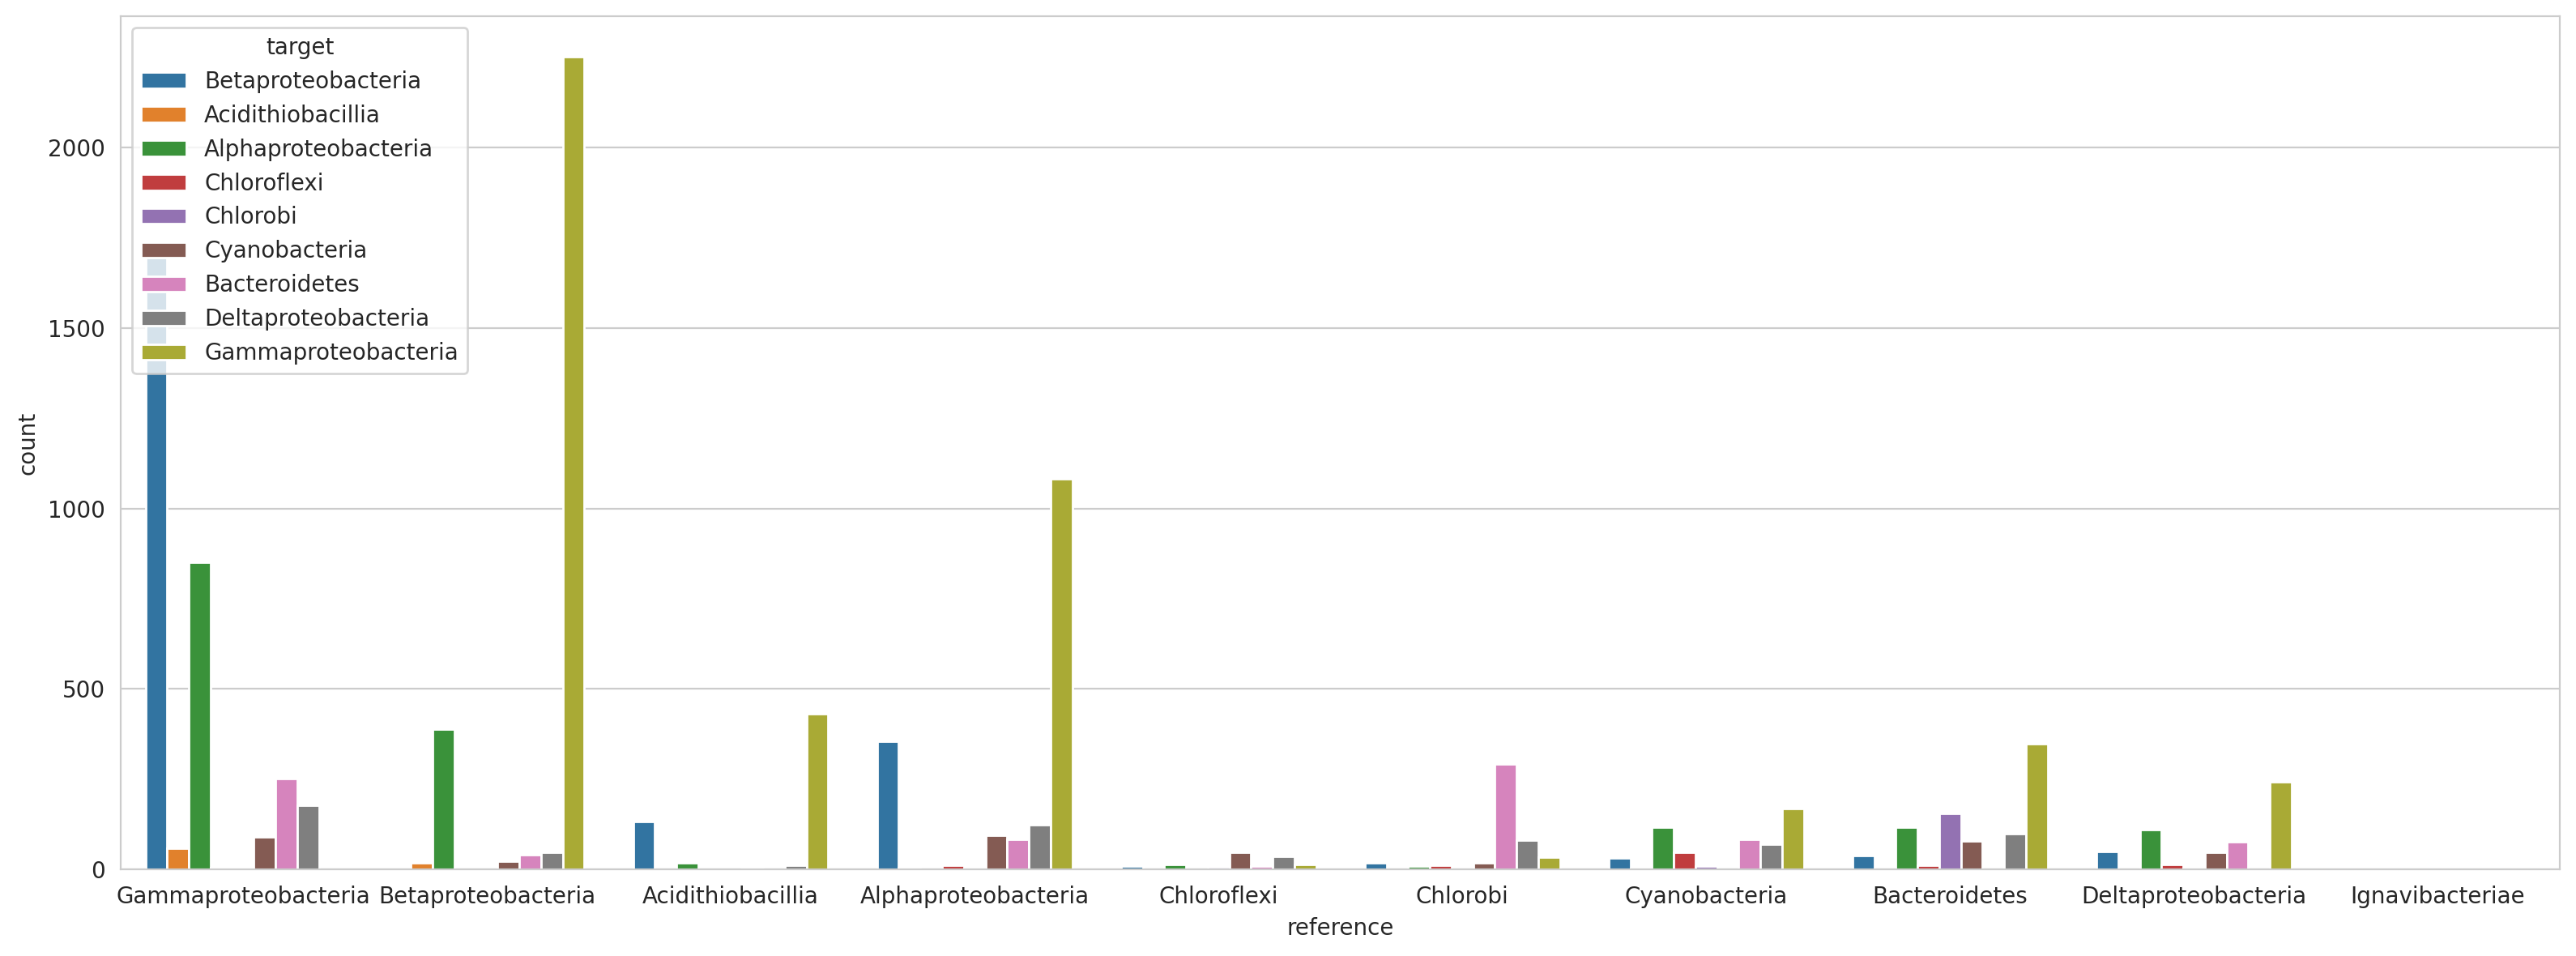

In [46]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(dpi=200, figsize=(16, 6))
    sns.barplot(x='reference', y='count', hue='target', data=closest_relation_freq, ax=ax)
    fig.tight_layout();

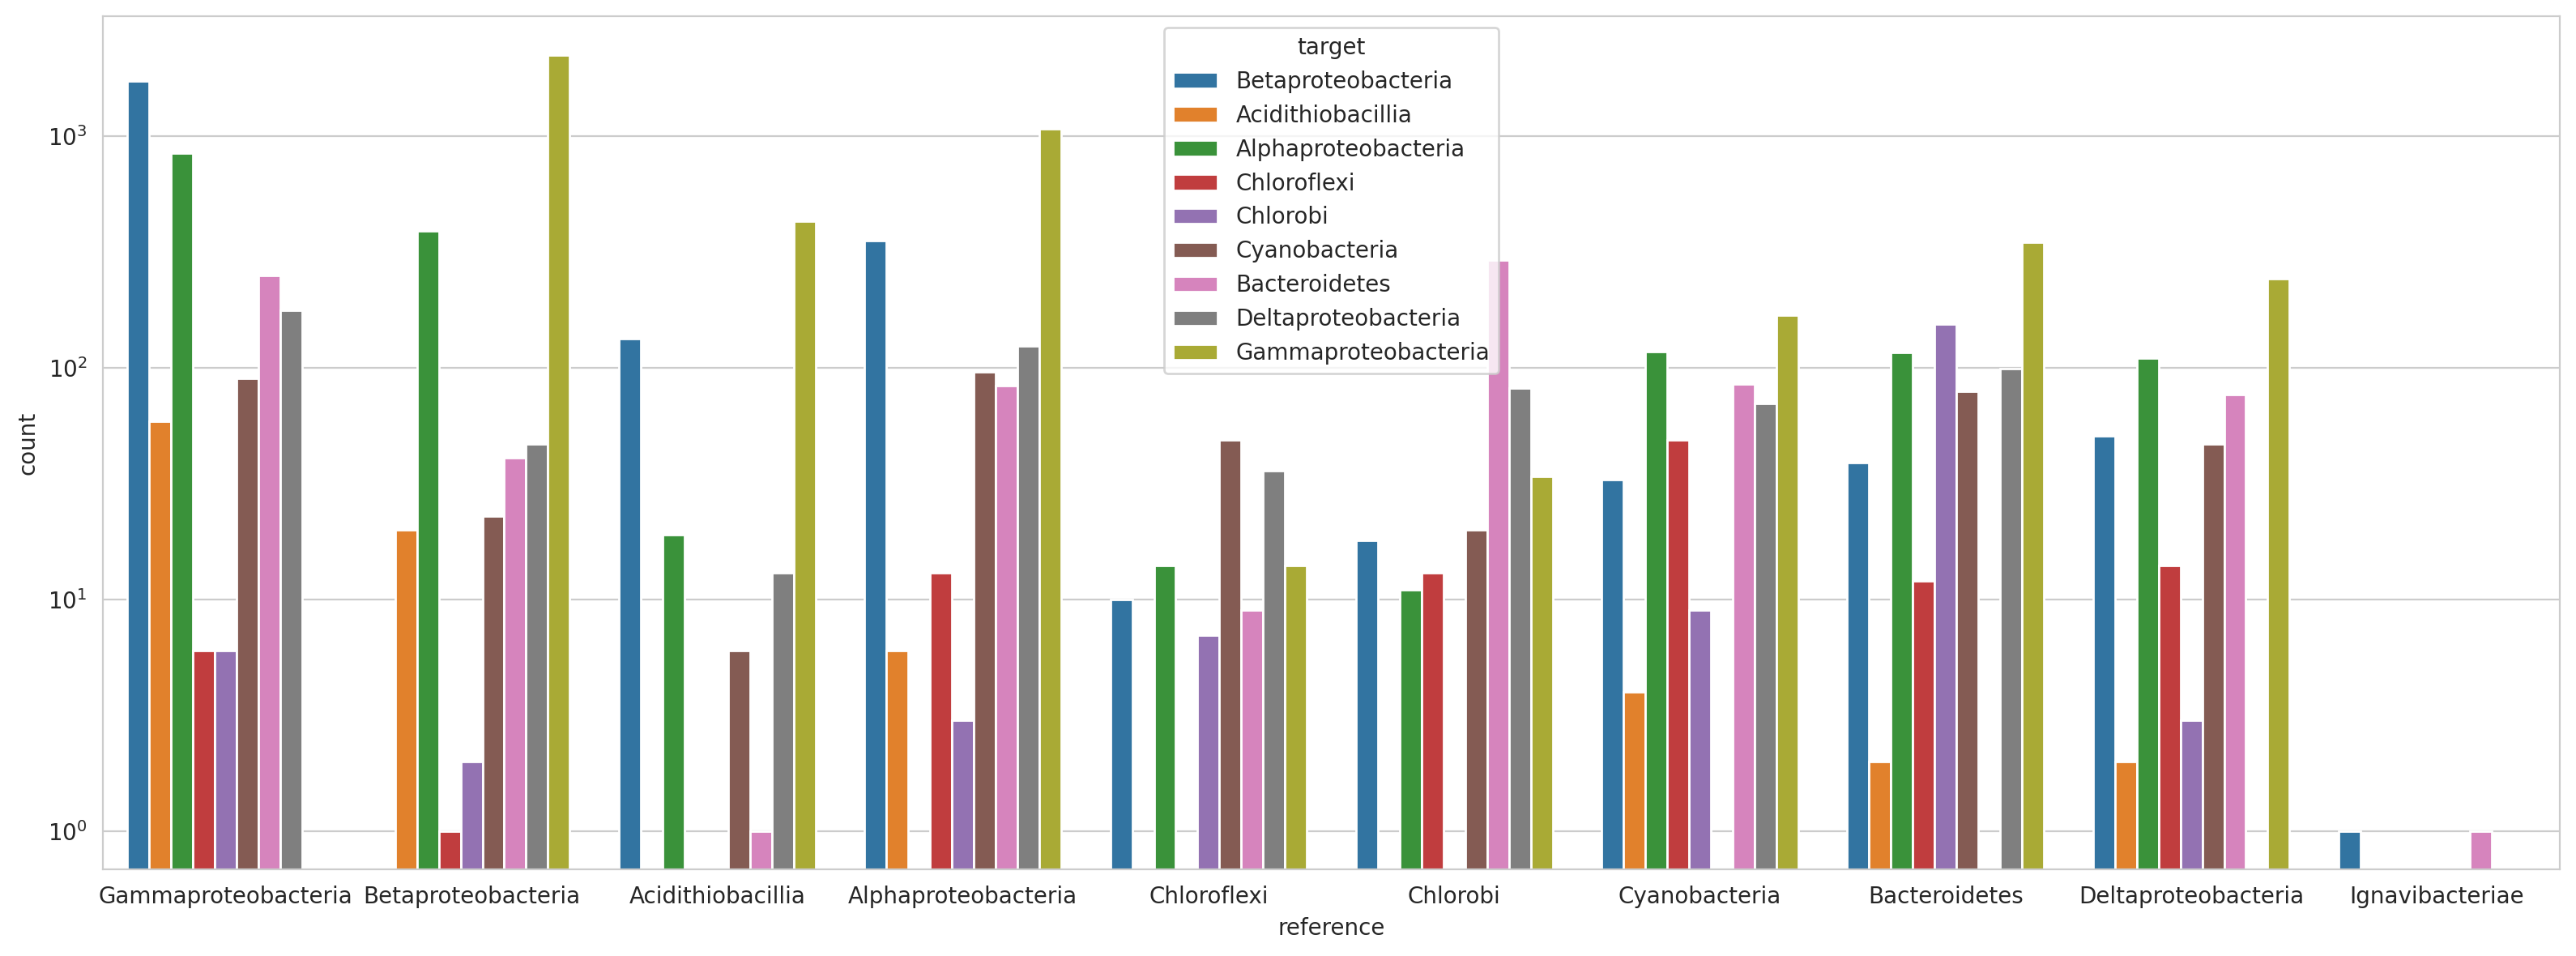

In [47]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(dpi=200, figsize=(16, 6))
    sns.barplot(x='reference', y='count', hue='target', data=closest_relation_freq, ax=ax)
    ax.set(yscale="log")
    fig.tight_layout();

In [14]:
closest_relation_freq.query('count>400')

,reference,target,count
0,Gammaproteobacteria,Betaproteobacteria,1740.0
2,Gammaproteobacteria,Alphaproteobacteria,850.0
8,Betaproteobacteria,Gammaproteobacteria,2250.0
16,Acidithiobacillia,Gammaproteobacteria,431.0
22,Alphaproteobacteria,Gammaproteobacteria,1083.0


In [15]:
closest_relation_freq.query('count<400')

,reference,target,count
1,Gammaproteobacteria,Acidithiobacillia,59.0
3,Gammaproteobacteria,Chloroflexi,6.0
4,Gammaproteobacteria,Chlorobi,6.0
5,Gammaproteobacteria,Cyanobacteria,90.0
6,Gammaproteobacteria,Bacteroidetes,252.0
...,...,...,...
65,Deltaproteobacteria,Chlorobi,3.0
66,Deltaproteobacteria,Cyanobacteria,47.0
67,Deltaproteobacteria,Bacteroidetes,77.0
68,Ignavibacteriae,Betaproteobacteria,1.0


In [16]:
closest_relation_freq.query('reference.str.contains("proteo") & count>400')

,reference,target,count
0,Gammaproteobacteria,Betaproteobacteria,1740.0
2,Gammaproteobacteria,Alphaproteobacteria,850.0
8,Betaproteobacteria,Gammaproteobacteria,2250.0
22,Alphaproteobacteria,Gammaproteobacteria,1083.0


In [17]:
closest_relation_freq.query('reference.str.contains("proteo") & count<400').sort_values(by='count')

,reference,target,count
11,Betaproteobacteria,Chloroflexi,1.0
12,Betaproteobacteria,Chlorobi,2.0
62,Deltaproteobacteria,Acidithiobacillia,2.0
26,Alphaproteobacteria,Chlorobi,3.0
65,Deltaproteobacteria,Chlorobi,3.0
4,Gammaproteobacteria,Chlorobi,6.0
3,Gammaproteobacteria,Chloroflexi,6.0
24,Alphaproteobacteria,Acidithiobacillia,6.0
25,Alphaproteobacteria,Chloroflexi,13.0
64,Deltaproteobacteria,Chloroflexi,14.0


In [83]:
closest_relation_freq.sort_values(by='count').to_excel("closest_relation_freq.xlsx")

In [14]:
### Begin analysis

In [9]:
#
# fastTree
#

def assess_transfers_between_phyla(related_phyla):
# related_phyla = (1090, 1117)

    candidates    = set(significant_df.query('source=="%i" and target=="%i"' % related_phyla).group.values).union(
                        significant_df.query('target=="%i" and source=="%i"' % related_phyla).group.values
                    )
    descriptions  = {f'from {related_phyla[0]} to {related_phyla[1]}': set(),
                     f'from {related_phyla[1]} to {related_phyla[0]}': set(),
                      'sisters':                                       set(),
                      'no clear relationship between phyla':           set()}

    for candidate in candidates:

        group_id, cluster_num = candidate.split('#')

        with cd('candidates/'):
            #
            # test if there is rooted version of the tree (mad output) 
            if not os.path.isfile('trees/%s-cluster%s.fastTree.rooted' % (group_id, cluster_num)):
                  reconstruct_candidate_fastTree(candidate)

            #
            # we need the original tree cause mad removes support values, so we just transfer root positions
            try:
                tmp_tree   = match_rooting(ete3.Tree('trees/%s-cluster%s.fastTree.rooted' % (group_id, cluster_num)),
                                           ete3.Tree('trees/%s-cluster%s.fastTree'        % (group_id, cluster_num)))
            except ete3.parser.newick.NewickError:
                continue

        #
        # extract taxIDs to subsample taxonomy tables
        taxids = {}
        for leaf in tmp_tree.get_leaf_names():
            #
            # leaf names are composed by <taxid>.<locus_tag>
            #   ps: locus_tag may also have "." within it
            tmp_taxid = int(leaf.split('.')[0])

            if tmp_taxid not in taxids:
                taxids[tmp_taxid] = []
            taxids[tmp_taxid].append(leaf)

        #
        # select taxIDs from each assessed phylum...
        phylum1_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[0]')
        phylum2_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[1]')

        #
        # ... and their respect leaves
        phylum1_leaves = set()
        for taxid in phylum1_taxonomy.index:
            phylum1_leaves.update(taxids[taxid])

        phylum2_leaves = set()
        for taxid in phylum2_taxonomy.index:
            phylum2_leaves.update(taxids[taxid])
        
        all_leaves = phylum1_leaves.union(phylum2_leaves)

        #
        # as tree traversing through ete3 isn't very efficient, and doesn't scalate very well,
        #   we create an iGraph dag for more effient traversing
        dag  = tree_to_dag(tmp_tree)          # we need a directed version...
        udag = dag.as_undirected(mode='each') # ... and an undirected one for different processes

        #
        # placeholders where we will add monophyletic clades for each phylum
        phylum1_clades = set() 
        phylum2_clades = set()

        ignored_nodes  = [] # descendants of monophyletic nodes should be ignored once their
                            #   ancestors have been stored.

        #
        # traverse through internal nodes
        for node in dag.vs:
            if node.index in ignored_nodes:
                continue

            node_leaves = get_leaf_names(node)

            if all_leaves.isdisjoint(node_leaves):
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            #
            # if there aren't leaves from other phyla within this node it is monophyletic
            if phylum1_leaves.intersection(node_leaves) and phylum1_leaves.issuperset(node_leaves):
                phylum1_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            elif phylum2_leaves.intersection(node_leaves) and phylum2_leaves.issuperset(node_leaves):
                phylum2_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

        #
        # now we add some flexibility to the monophyly of nodes for three reasons:
        #   1) donor nodes within gene trees will never be monophyletic since the recipient
        #      must be nested within it.
        #   2) if there are other transfers from the donor and/or recipient phyla to a 3rd one
        #      we still want to capture it.
        #   3) good ol' phylogenetic uncertainty
        phylum1_clades = merge_polyphyletic_clades(phylum1_clades, udag)
        phylum2_clades = merge_polyphyletic_clades(phylum2_clades, udag)

        #
        # flag if we can identify relations between phyla:
        #   1 nested within 2
        #   2 nested within 1
        #   1 and 2 are sisters
        #
        # if no relation is identified, leave as false
        phyla_relationship_flag = 0

        for clade1, clade2 in itertools.product(phylum1_clades, phylum2_clades):

            #
            # capture ancestors of clade1 by querying nodes between itself and the root node
            clade1_ancestors = udag.vs[clade1].get_shortest_paths(udag.vs[0])[0][1:]
            #
            # if clade2 within clade1 ancestors it means that clade1 is nested within clade2
            #   evidence of transfer from clade2 -> clade1
            if clade2 in clade1_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                donor_taxon             = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                phyla_relationship_flag = 1
                
                if (recipient_taxon, donor_taxon) != related_phyla:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add(candidate)

                continue

            #
            # if clade1 within clade2 ancestors it means that clade2 is nested within clade1
            #   evidence of transfer from clade1 -> clade2
            clade2_ancestors = udag.vs[clade2].get_shortest_paths(udag.vs[0])[0][1:]
            if clade1 in clade2_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                donor_taxon             = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                phyla_relationship_flag = 1

                if (donor_taxon, recipient_taxon) !=  related_phyla:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add(candidate)
                continue

            #
            # if clade1 and clade2 are have the same parent noe it means they are sisters
            #   evidence of hgt, but information about directionality
            if clade1_ancestors[0] == clade2_ancestors[0]:
                descriptions['sisters'].add(candidate)
                phyla_relationship_flag = 1
                continue

    #     with cd('candidates/'):
    #         with open('%s-cluster%s.figTree' % (group_id, cluster_num), 'w') as out:
    #             out.write(visualize_reconstruct_candidate(tmp_tree))

        #
        # if the flag still is False, we couldn't identify an relationship between phyla
        if not phyla_relationship_flag:
            descriptions['no clear relationship between phyla'].add(candidate)

    return(descriptions)

In [10]:
def assess_transfers_between_phyla2(related_phyla):
# related_phyla = (1090, 1117)

    candidates    = set(significant_df.query('source=="%i" and target=="%i"' % related_phyla).group.values).union(
                        significant_df.query('target=="%i" and source=="%i"' % related_phyla).group.values
                    )
    descriptions  = {f'from {related_phyla[0]} to {related_phyla[1]}': set(),
                     f'from {related_phyla[1]} to {related_phyla[0]}': set(),
                      'sisters':                                       set(),
                      'no clear relationship between phyla':           set()}

    for candidate in candidates:

        group_id, cluster_num = candidate.split('#')

        with cd('candidates/'):
            #
            # test if there is rooted version of the tree (mad output) 
            if not os.path.isfile('trees/%s-cluster%s.fastFigTree' % (group_id, cluster_num)):
                   visualize_reconstruct_candidate_fastTree2(candidate)

            #
            # we need the original tree cause mad removes support values, so we just transfer root positions
            try:
                tmp_tree   = match_rooting(ete3.Tree('trees/%s-cluster%s.treefile.rooted' % (group_id, cluster_num)),
                                           ete3.Tree('trees/%s-cluster%s.treefile'        % (group_id, cluster_num)))
            except ete3.parser.newick.NewickError:
                continue

        #
        # extract taxIDs to subsample taxonomy tables
        taxids = {}
        for leaf in tmp_tree.get_leaf_names():
            #
            # leaf names are composed by <taxid>.<locus_tag>
            #   ps: locus_tag may also have "." within it
            tmp_taxid = int(leaf.split('.')[0])

            if tmp_taxid not in taxids:
                taxids[tmp_taxid] = []
            taxids[tmp_taxid].append(leaf)

        #
        # select taxIDs from each assessed phylum...
        phylum1_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[0]')
        phylum2_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[1]')

        #
        # ... and their respect leaves
        phylum1_leaves = set()
        for taxid in phylum1_taxonomy.index:
            phylum1_leaves.update(taxids[taxid])

        phylum2_leaves = set()
        for taxid in phylum2_taxonomy.index:
            phylum2_leaves.update(taxids[taxid])
        
        all_leaves = phylum1_leaves.union(phylum2_leaves)

        #
        # as tree traversing through ete3 isn't very efficient, and doesn't scalate very well,
        #   we create an iGraph dag for more effient traversing
        dag  = tree_to_dag(tmp_tree)          # we need a directed version...
        udag = dag.as_undirected(mode='each') # ... and an undirected one for different processes

        #
        # placeholders where we will add monophyletic clades for each phylum
        phylum1_clades = set() 
        phylum2_clades = set()

        ignored_nodes  = [] # descendants of monophyletic nodes should be ignored once their
                            #   ancestors have been stored.

        #
        # traverse through internal nodes
        for node in dag.vs:
            if node.index in ignored_nodes:
                continue

            node_leaves = get_leaf_names(node)

            if all_leaves.isdisjoint(node_leaves):
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            #
            # if there aren't leaves from other phyla within this node it is monophyletic
            if phylum1_leaves.intersection(node_leaves) and phylum1_leaves.issuperset(node_leaves):
                phylum1_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            elif phylum2_leaves.intersection(node_leaves) and phylum2_leaves.issuperset(node_leaves):
                phylum2_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

        #
        # now we add some flexibility to the monophyly of nodes for three reasons:
        #   1) donor nodes within gene trees will never be monophyletic since the recipient
        #      must be nested within it.
        #   2) if there are other transfers from the donor and/or recipient phyla to a 3rd one
        #      we still want to capture it.
        #   3) good ol' phylogenetic uncertainty
        phylum1_clades = merge_polyphyletic_clades(phylum1_clades, udag)
        phylum2_clades = merge_polyphyletic_clades(phylum2_clades, udag)

        #
        # flag if we can identify relations between phyla:
        #   1 nested within 2
        #   2 nested within 1
        #   1 and 2 are sisters
        #
        # if no relation is identified, leave as false
        phyla_relationship_flag = 0

        for clade1, clade2 in itertools.product(phylum1_clades, phylum2_clades):

            #
            # capture ancestors of clade1 by querying nodes between itself and the root node
            clade1_ancestors = udag.vs[clade1].get_shortest_paths(udag.vs[0])[0][1:]
            #
            # if clade2 within clade1 ancestors it means that clade1 is nested within clade2
            #   evidence of transfer from clade2 -> clade1
            if clade2 in clade1_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                donor_taxon             = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                phyla_relationship_flag = 1
                
                if (recipient_taxon, donor_taxon) != related_phyla:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add(candidate)

                continue

            #
            # if clade1 within clade2 ancestors it means that clade2 is nested within clade1
            #   evidence of transfer from clade1 -> clade2
            clade2_ancestors = udag.vs[clade2].get_shortest_paths(udag.vs[0])[0][1:]
            if clade1 in clade2_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                donor_taxon             = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                phyla_relationship_flag = 1

                if (donor_taxon, recipient_taxon) !=  related_phyla:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add(candidate)
                continue

            #
            # if clade1 and clade2 are have the same parent noe it means they are sisters
            #   evidence of hgt, but information about directionality
            if clade1_ancestors[0] == clade2_ancestors[0]:
                descriptions['sisters'].add(candidate)
                phyla_relationship_flag = 1
                continue

    #     with cd('candidates/'):
    #         with open('%s-cluster%s.figTree' % (group_id, cluster_num), 'w') as out:
    #             out.write(visualize_reconstruct_candidate(tmp_tree))

        #
        # if the flag still is False, we couldn't identify an relationship between phyla
        if not phyla_relationship_flag:
            descriptions['no clear relationship between phyla'].add(candidate)

    return(descriptions)

In [48]:
def assess_transfers_between_phyla3(related_phyla):
# related_phyla = (1090, 1117)

    candidates    = set(significant_df.query('source=="%i" and target=="%i"' % related_phyla).group.values).union(
                        significant_df.query('target=="%i" and source=="%i"' % related_phyla).group.values
                    )
    descriptions  = {f'from {related_phyla[0]} to {related_phyla[1]}': set(),
                     f'from {related_phyla[1]} to {related_phyla[0]}': set(),
                      'sisters':                                       set(),
                      'no clear relationship between phyla':           set()}

    for candidate in candidates:

        group_id, cluster_num = candidate.split('#')

        with cd('candidates/'):
            #
            # test if there is rooted version of the tree (mad output) 
            if not os.path.isfile('trees/%s-cluster%s.treefile' % (group_id, cluster_num)):
                   reconstruct_candidate(candidate)

            #
            # we need the original tree cause mad removes support values, so we just transfer root positions
            try:
                tmp_tree   = match_rooting(ete3.Tree('trees/%s-cluster%s.treefile.rooted' % (group_id, cluster_num)),
                                           ete3.Tree('trees/%s-cluster%s.treefile'        % (group_id, cluster_num)))
            except ete3.parser.newick.NewickError:
                continue

        #
        # extract taxIDs to subsample taxonomy tables
        taxids = {}
        for leaf in tmp_tree.get_leaf_names():
            #
            # leaf names are composed by <taxid>.<locus_tag>
            #   ps: locus_tag may also have "." within it
            tmp_taxid = int(leaf.split('.')[0])

            if tmp_taxid not in taxids:
                taxids[tmp_taxid] = []
            taxids[tmp_taxid].append(leaf)

        #
        # select taxIDs from each assessed phylum...
        phylum1_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[0]')
        phylum2_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[1]')

        #
        # ... and their respect leaves
        phylum1_leaves = set()
        for taxid in phylum1_taxonomy.index:
            phylum1_leaves.update(taxids[taxid])

        phylum2_leaves = set()
        for taxid in phylum2_taxonomy.index:
            phylum2_leaves.update(taxids[taxid])
        
        all_leaves = phylum1_leaves.union(phylum2_leaves)

        #
        # as tree traversing through ete3 isn't very efficient, and doesn't scalate very well,
        #   we create an iGraph dag for more effient traversing
        dag  = tree_to_dag(tmp_tree)          # we need a directed version...
        udag = dag.as_undirected(mode='each') # ... and an undirected one for different processes

        #
        # placeholders where we will add monophyletic clades for each phylum
        phylum1_clades = set() 
        phylum2_clades = set()

        ignored_nodes  = [] # descendants of monophyletic nodes should be ignored once their
                            #   ancestors have been stored.

        #
        # traverse through internal nodes
        for node in dag.vs:
            if node.index in ignored_nodes:
                continue

            node_leaves = get_leaf_names(node)

            if all_leaves.isdisjoint(node_leaves):
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            #
            # if there aren't leaves from other phyla within this node it is monophyletic
            if phylum1_leaves.intersection(node_leaves) and phylum1_leaves.issuperset(node_leaves):
                phylum1_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            elif phylum2_leaves.intersection(node_leaves) and phylum2_leaves.issuperset(node_leaves):
                phylum2_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

        #
        # now we add some flexibility to the monophyly of nodes for three reasons:
        #   1) donor nodes within gene trees will never be monophyletic since the recipient
        #      must be nested within it.
        #   2) if there are other transfers from the donor and/or recipient phyla to a 3rd one
        #      we still want to capture it.
        #   3) good ol' phylogenetic uncertainty
        phylum1_clades = merge_polyphyletic_clades(phylum1_clades, udag)
        phylum2_clades = merge_polyphyletic_clades(phylum2_clades, udag)

        #
        # flag if we can identify relations between phyla:
        #   1 nested within 2
        #   2 nested within 1
        #   1 and 2 are sisters
        #
        # if no relation is identified, leave as false
        phyla_relationship_flag = 0

        for clade1, clade2 in itertools.product(phylum1_clades, phylum2_clades):

            #
            # capture ancestors of clade1 by querying nodes between itself and the root node
            clade1_ancestors = udag.vs[clade1].get_shortest_paths(udag.vs[0])[0][1:]
            #
            # if clade2 within clade1 ancestors it means that clade1 is nested within clade2
            #   evidence of transfer from clade2 -> clade1
            if clade2 in clade1_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                donor_taxon             = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                phyla_relationship_flag = 1
                
                if (recipient_taxon, donor_taxon) != related_phyla:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add(candidate)

                continue

            #
            # if clade1 within clade2 ancestors it means that clade2 is nested within clade1
            #   evidence of transfer from clade1 -> clade2
            clade2_ancestors = udag.vs[clade2].get_shortest_paths(udag.vs[0])[0][1:]
            if clade1 in clade2_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                donor_taxon             = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                phyla_relationship_flag = 1

                if (donor_taxon, recipient_taxon) !=  related_phyla:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add(candidate)
                continue

            #
            # if clade1 and clade2 are have the same parent noe it means they are sisters
            #   evidence of hgt, but information about directionality
            if clade1_ancestors[0] == clade2_ancestors[0]:
                descriptions['sisters'].add(candidate)
                phyla_relationship_flag = 1
                continue

    #     with cd('candidates/'):
    #         with open('%s-cluster%s.figTree' % (group_id, cluster_num), 'w') as out:
    #             out.write(visualize_reconstruct_candidate(tmp_tree))

        #
        # if the flag still is False, we couldn't identify an relationship between phyla
        if not phyla_relationship_flag:
            descriptions['no clear relationship between phyla'].add(candidate)

    return(descriptions)

In [49]:
#Example of pipeline -- reconstruct & visualize
#
#reconstruct_candidate_fastTree('COG0049#3')
#visualize_reconstruct_candidate_fastTree2('COG0049#3')
#
# # descriptions = assess_transfers_between_phyla((200795, 1117))

In [50]:
print(sampled_phyla)

[1236, 28216, 1807140, 28211, 200795, 1090, 1117, 976, 28221, 1134404]


In [51]:
for each in itertools.combinations(sampled_phyla, 2):
    print(each)

(1236, 28216)
(1236, 1807140)
(1236, 28211)
(1236, 200795)
(1236, 1090)
(1236, 1117)
(1236, 976)
(1236, 28221)
(1236, 1134404)
(28216, 1807140)
(28216, 28211)
(28216, 200795)
(28216, 1090)
(28216, 1117)
(28216, 976)
(28216, 28221)
(28216, 1134404)
(1807140, 28211)
(1807140, 200795)
(1807140, 1090)
(1807140, 1117)
(1807140, 976)
(1807140, 28221)
(1807140, 1134404)
(28211, 200795)
(28211, 1090)
(28211, 1117)
(28211, 976)
(28211, 28221)
(28211, 1134404)
(200795, 1090)
(200795, 1117)
(200795, 976)
(200795, 28221)
(200795, 1134404)
(1090, 1117)
(1090, 976)
(1090, 28221)
(1090, 1134404)
(1117, 976)
(1117, 28221)
(1117, 1134404)
(976, 28221)
(976, 1134404)
(28221, 1134404)


In [15]:
print(sampled_phyla)

[1236, 28216, 1807140, 28211, 200795, 1090, 1117, 976, 28221, 1134404]


In [16]:
#Unique selected phyla/class pairings
#(28216, 200795)
#(28211, 1090)
#(1236, 200795)
#(28216, 1090)
#(28211, 200795)
#(1236, 1090)
#(200795, 28221)
#(28216, 1117)
#(1090, 28221)
#(28216, 28221)
#(1117, 28221)
#(28211, 1117)
#(28211, 28221)
#(1236, 1117)

In [17]:
sub_sampled_phyla = ((28216, 200795),
                     (28211, 1090),
                     (1236, 200795),
                     (28216, 1090),
                     (28211, 200795),
                     (1236, 1090),
                     (200795, 28221),
                     (28216, 1117),
                     (1090, 28221),
                     (28216, 28221),
                     (1117, 28221),
                     (28211, 1117),
                     (28211, 28221),
                     (1236, 1117))

In [22]:
for phylum_pair in sub_sampled_phyla:
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)

{28216: 'Betaproteobacteria', 200795: 'Chloroflexi'}
(28216, 200795)
{28211: 'Alphaproteobacteria', 1090: 'Chlorobi'}
(28211, 1090)
{1236: 'Gammaproteobacteria', 200795: 'Chloroflexi'}
(1236, 200795)
{28216: 'Betaproteobacteria', 1090: 'Chlorobi'}
(28216, 1090)
{28211: 'Alphaproteobacteria', 200795: 'Chloroflexi'}
(28211, 200795)
{1236: 'Gammaproteobacteria', 1090: 'Chlorobi'}
(1236, 1090)
{200795: 'Chloroflexi', 28221: 'Deltaproteobacteria'}
(200795, 28221)
{28216: 'Betaproteobacteria', 1117: 'Cyanobacteria'}
(28216, 1117)
{1090: 'Chlorobi', 28221: 'Deltaproteobacteria'}
(1090, 28221)
{28216: 'Betaproteobacteria', 28221: 'Deltaproteobacteria'}
(28216, 28221)
{1117: 'Cyanobacteria', 28221: 'Deltaproteobacteria'}
(1117, 28221)
{28211: 'Alphaproteobacteria', 1117: 'Cyanobacteria'}
(28211, 1117)
{28211: 'Alphaproteobacteria', 28221: 'Deltaproteobacteria'}
(28211, 28221)
{1236: 'Gammaproteobacteria', 1117: 'Cyanobacteria'}
(1236, 1117)


In [128]:
descriptions = {}
for phylum_pair in sub_sampled_phyla:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions[phylum_pair] = assess_transfers_between_phyla(phylum_pair) #assess transfers, then reconstruct

{28216: 'Betaproteobacteria', 200795: 'Chloroflexi'}
(28216, 200795)
{28211: 'Alphaproteobacteria', 1090: 'Chlorobi'}
(28211, 1090)
{1236: 'Gammaproteobacteria', 200795: 'Chloroflexi'}
(1236, 200795)
{28216: 'Betaproteobacteria', 1090: 'Chlorobi'}
(28216, 1090)
{28211: 'Alphaproteobacteria', 200795: 'Chloroflexi'}
(28211, 200795)
{1236: 'Gammaproteobacteria', 1090: 'Chlorobi'}
(1236, 1090)
{200795: 'Chloroflexi', 28221: 'Deltaproteobacteria'}
(200795, 28221)
{28216: 'Betaproteobacteria', 1117: 'Cyanobacteria'}
(28216, 1117)
{1090: 'Chlorobi', 28221: 'Deltaproteobacteria'}
(1090, 28221)
{28216: 'Betaproteobacteria', 28221: 'Deltaproteobacteria'}
(28216, 28221)
{1117: 'Cyanobacteria', 28221: 'Deltaproteobacteria'}
(1117, 28221)
{28211: 'Alphaproteobacteria', 1117: 'Cyanobacteria'}
(28211, 1117)
{28211: 'Alphaproteobacteria', 28221: 'Deltaproteobacteria'}
(28211, 28221)
{1236: 'Gammaproteobacteria', 1117: 'Cyanobacteria'}
(1236, 1117)


In [130]:
for pair, description in descriptions.items():
    print(pair)
    for key, value in description.items():
        print(key, len(value))
    print()

(28216, 200795)
from 28216 to 200795 3
from 200795 to 28216 2
sisters 1
no clear relationship between phyla 5

(28211, 1090)
from 28211 to 1090 4
from 1090 to 28211 0
sisters 0
no clear relationship between phyla 7

(1236, 200795)
from 1236 to 200795 3
from 200795 to 1236 2
sisters 3
no clear relationship between phyla 12

(28216, 1090)
from 28216 to 1090 9
from 1090 to 28216 0
sisters 3
no clear relationship between phyla 6

(28211, 200795)
from 28211 to 200795 6
from 200795 to 28211 5
sisters 4
no clear relationship between phyla 7

(1236, 1090)
from 1236 to 1090 25
from 1090 to 1236 1
sisters 5
no clear relationship between phyla 7

(200795, 28221)
from 200795 to 28221 12
from 28221 to 200795 22
sisters 6
no clear relationship between phyla 12

(28216, 1117)
from 28216 to 1117 8
from 1117 to 28216 12
sisters 14
no clear relationship between phyla 12

(1090, 28221)
from 1090 to 28221 2
from 28221 to 1090 57
sisters 12
no clear relationship between phyla 18

(28216, 28221)
from 28216 

In [ ]:
#for pair, description in descriptions.items():
    #print(pair)
#    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
#                                   for phylum in pair}
#    print(phylum_names)
    #print(ncbi.translate_to_names([int(pair)])[0] )
    #for key, value in description.items():
    #    print(key, len(value))
    #print()

In [131]:
for pair, description in descriptions.items():
    print(pair)
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in pair}
    print(phylum_names)
    for key, value in description.items():
        print(key, len(value))
    print()

(28216, 200795)
{28216: 'Betaproteobacteria', 200795: 'Chloroflexi'}
from 28216 to 200795 3
from 200795 to 28216 2
sisters 1
no clear relationship between phyla 5

(28211, 1090)
{28211: 'Alphaproteobacteria', 1090: 'Chlorobi'}
from 28211 to 1090 4
from 1090 to 28211 0
sisters 0
no clear relationship between phyla 7

(1236, 200795)
{1236: 'Gammaproteobacteria', 200795: 'Chloroflexi'}
from 1236 to 200795 3
from 200795 to 1236 2
sisters 3
no clear relationship between phyla 12

(28216, 1090)
{28216: 'Betaproteobacteria', 1090: 'Chlorobi'}
from 28216 to 1090 9
from 1090 to 28216 0
sisters 3
no clear relationship between phyla 6

(28211, 200795)
{28211: 'Alphaproteobacteria', 200795: 'Chloroflexi'}
from 28211 to 200795 6
from 200795 to 28211 5
sisters 4
no clear relationship between phyla 7

(1236, 1090)
{1236: 'Gammaproteobacteria', 1090: 'Chlorobi'}
from 1236 to 1090 25
from 1090 to 1236 1
sisters 5
no clear relationship between phyla 7

(200795, 28221)
{200795: 'Chloroflexi', 28221: 'Del

In [132]:
for pair, description in descriptions.items():
    print(pair)
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in pair}
    print(phylum_names)
    for key, value in description.items():
        print(key, value)
    print()

(28216, 200795)
{28216: 'Betaproteobacteria', 200795: 'Chloroflexi'}
from 28216 to 200795 {'COG0123#2 from 28216 to 120961', 'COG2962#3', 'COG0123#2 from 28216 to 1107'}
from 200795 to 28216 {'COG2040#2 from 200795 to 40545', 'COG2040#2'}
sisters {'COG3042#2'}
no clear relationship between phyla {'COG4243#0', 'COG1238#0', 'COG1346#0', 'COG0523#5', 'COG0511#5'}

(28211, 1090)
{28211: 'Alphaproteobacteria', 1090: 'Chlorobi'}
from 28211 to 1090 {'COG0233#3 from 28211 to 191411', 'COG3347#1 from 28211 to 191412', 'COG3847#0 from 28211 to 191412', 'COG1830#0 from 28211 to 191412'}
from 1090 to 28211 set()
sisters set()
no clear relationship between phyla {'COG3845#4', 'COG0708#1', 'COG1305#5', 'COG0170#1', 'COG1304#5', 'COG1989#0', 'COG4591#1'}

(1236, 200795)
{1236: 'Gammaproteobacteria', 200795: 'Chloroflexi'}
from 1236 to 200795 {'COG2919#2 from 1236 to 65', 'COG2717#0', 'COG2919#2'}
from 200795 to 1236 {'COG0065#5', 'COG0137#0'}
sisters {'COG1035#2', 'COG3280#0', 'COG0065#5'}
no clear r

In [18]:
os.chdir('/nobackup1c/users/payette/eggNOGbyClass1/')
!pwd

/nobackup1c/users/payette/eggNOGbyClass1


In [210]:
descriptions2 = {}
for phylum_pair in sub_sampled_phyla:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions2[phylum_pair] = assess_transfers_between_phyla2(phylum_pair) #assess transfers, then reconstruct

{28216: 'Betaproteobacteria', 200795: 'Chloroflexi'}
(28216, 200795)
{28211: 'Alphaproteobacteria', 1090: 'Chlorobi'}
(28211, 1090)
{1236: 'Gammaproteobacteria', 200795: 'Chloroflexi'}
(1236, 200795)
{28216: 'Betaproteobacteria', 1090: 'Chlorobi'}
(28216, 1090)
{28211: 'Alphaproteobacteria', 200795: 'Chloroflexi'}
(28211, 200795)
{1236: 'Gammaproteobacteria', 1090: 'Chlorobi'}
(1236, 1090)
{200795: 'Chloroflexi', 28221: 'Deltaproteobacteria'}
(200795, 28221)
{28216: 'Betaproteobacteria', 1117: 'Cyanobacteria'}
(28216, 1117)
{1090: 'Chlorobi', 28221: 'Deltaproteobacteria'}
(1090, 28221)
{28216: 'Betaproteobacteria', 28221: 'Deltaproteobacteria'}
(28216, 28221)
{1117: 'Cyanobacteria', 28221: 'Deltaproteobacteria'}
(1117, 28221)
{28211: 'Alphaproteobacteria', 1117: 'Cyanobacteria'}
(28211, 1117)
{28211: 'Alphaproteobacteria', 28221: 'Deltaproteobacteria'}
(28211, 28221)
{1236: 'Gammaproteobacteria', 1117: 'Cyanobacteria'}
(1236, 1117)


In [ ]:
descriptions3 = {}
for phylum_pair in sub_sampled_phyla:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions3[phylum_pair] = assess_transfers_between_phyla3(phylum_pair) #assess transfers, then reconstruct

{28216: 'Betaproteobacteria', 200795: 'Chloroflexi'}
(28216, 200795)
{28211: 'Alphaproteobacteria', 1090: 'Chlorobi'}
(28211, 1090)
{1236: 'Gammaproteobacteria', 200795: 'Chloroflexi'}
(1236, 200795)
{28216: 'Betaproteobacteria', 1090: 'Chlorobi'}
(28216, 1090)
{28211: 'Alphaproteobacteria', 200795: 'Chloroflexi'}
(28211, 200795)
{1236: 'Gammaproteobacteria', 1090: 'Chlorobi'}
(1236, 1090)
{200795: 'Chloroflexi', 28221: 'Deltaproteobacteria'}
(200795, 28221)
{28216: 'Betaproteobacteria', 1117: 'Cyanobacteria'}
(28216, 1117)
{1090: 'Chlorobi', 28221: 'Deltaproteobacteria'}
(1090, 28221)


In [32]:
os.chdir('/nobackup1c/users/payette/eggNOGbyClass1')
!pwd

/nobackup1c/users/payette/eggNOGbyClass1


In [31]:
print('Chloroflexi & Deltaproteobacteria')
assess_transfers_between_phyla((200795, 28221)) 

Chloroflexi & Deltaproteobacteria


{'from 200795 to 28221': {'COG1718#1 from 200795 to 49'},
 'from 28221 to 200795': {'COG1739#3 from 28221 to 133453',
  'COG1739#3 from 28221 to 32064',
  'COG1739#3 from 28221 to 65'},
 'sisters': set(),
 'no clear relationship between phyla': set()}

In [73]:
reconstruct_candidate_fastTree('COG1718#1') #needs to be in candidates directory

In [75]:
visualize_reconstruct_candidate_fastTree2('COG1718#1') #visualizer has custom colors

In [92]:
#reconstruct_candidate('COG1718#1')

In [90]:
%%time
pool    = multiprocessing.Pool(processes=10, maxtasksperchild=5)
pool.imap(reconstruct_candidate, 'COG1718#1')
#pool.close()
#pool.join()

CPU times: user 20.8 ms, sys: 715 ms, total: 736 ms
Wall time: 726 ms


In [91]:
reconstruct_candidate('COG1718#1')

In [25]:
with open('fastTree_nested_proteo', 'wb') as out: #ran at 11:45 11-18-20
    pkl.dump(descriptions, out)

In [ ]:
####

In [38]:
assess_transfers_between_phyla((1090, 1224)) #Chlorobi & proteobacteria -- let's see if this works?!

{'from 1090 to 1224': {'COG0048#0 from 191411 to 49',
  'COG0267#1 from 191411 to 2024979',
  'COG1661#0 from 191412 to 453230',
  'COG4875#0 from 191412 to 1224'},
 'from 1224 to 1090': {'2Z80Y#2 from 28221 to 191412',
  '2Z9HB#1 from 1224 to 256319',
  '31GHU#5 from 1224 to 191412',
  '32Y6T#0 from 1224 to 191412',
  '32YCZ#0 from 1224 to 191412',
  '331C6#0 from 1224 to 191412',
  '339RM#0 from 1224 to 1096',
  '339RM#0 from 1224 to 191412',
  '339RM#0 from 1224 to 274539',
  'COG0050#1 from 1224 to 191411',
  'COG0064#1 from 1224 to 191411',
  'COG0139#0 from 1224 to 191411',
  'COG0149#3 from 1224 to 191411',
  'COG0161#2 from 1224 to 191412',
  'COG0166#4 from 1224 to 191411',
  'COG0166#4 from 1224 to 191412',
  'COG0170#1 from 1224 to 191411',
  'COG0217#1 from 1224 to 191412',
  'COG0222#0 from 1224 to 191411',
  'COG0227#1 from 1224 to 191411',
  'COG0233#3 from 28211 to 191411',
  'COG0247#11 from 1224 to 191412',
  'COG0247#7 from 1224 to 191412',
  'COG0248#4 from 1224 to 

In [43]:
descriptions2 = {}
sampled_phyla=(1090, 1224)
for phylum_pair in itertools.combinations(sampled_phyla, 2):
    print(phylum_pair)
    descriptions2[phylum_pair] = assess_transfers_between_phyla(phylum_pair)
    
# descriptions = assess_transfers_between_phyla((200795, 1117))

(1090, 1224)


In [44]:
for pair, description in descriptions2.items():
    print(pair)
    for key, value in description.items():
        print(key, len(value))
    print()

(1090, 1224)
from 1090 to 1224 4
from 1224 to 1090 239
sisters 12
no clear relationship between phyla 18



In [47]:
with open('fastTree_nested2', 'wb') as out: #ran at 11:45 11-18-20
    pkl.dump(descriptions2, out)

In [179]:
descriptions2.values()

dict_values([{'from 1090 to 1224': {'COG1661#0 from 191412 to 453230', 'COG0048#0 from 191411 to 49', 'COG4875#0 from 191412 to 1224', 'COG0267#1 from 191411 to 2024979'}, 'from 1224 to 1090': {'COG2326#0 from 1224 to 191412', 'COG1275#0 from 1224 to 191412', 'COG0507#9 from 1224 to 191412', 'COG0586#6 from 1224 to 191412', 'COG5607#0 from 1224 to 191412', 'COG0720#4 from 1224 to 191412', 'COG1607#6 from 1224 to 191412', 'COG1119#3 from 1224 to 191412', 'COG0170#1 from 1224 to 191411', 'COG4961#3 from 1224 to 191412', 'COG1169#1 from 1224 to 191412', 'COG0139#0 from 1224 to 191411', 'COG0773#1 from 1224 to 191411', 'COG1086#8 from 1224 to 191412', 'COG3381#0 from 1224 to 191412', 'COG4618#0 from 1224 to 191412', 'COG1237#0 from 1224 to 191412', 'COG1492#2 from 28221 to 100716', 'COG0348#8 from 1224 to 191412', 'COG1186#1 from 1224 to 1096', 'COG1067#0 from 1224 to 191412', '339RM#0 from 1224 to 274539', 'COG1322#3 from 1224 to 191412', 'COG0708#1 from 1224 to 191411', 'COG1578#2 from 1

In [208]:
def visualize_reconstructed_candidate(tree):
    
    out = "#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(tree)

    count               = 0
    internal_node_names = {}
    for node in tree.traverse():
        if node.is_leaf():
            taxid, locus_tag = node.name.split('.')
            try:
                lineage = {j: i for i, j in ncbi.get_rank(ncbi.get_lineage(taxid)).items()}
            except ValueError:
                out += '\t%s\n' %(node.name)
                continue
            else:
                lineage_names = ncbi.get_taxid_translator(lineage.values())

            out += '\t%s ' %(node.name)
            comment = []
            for rank in ['class', 'phylum', 'order', 'family', 'species']:
                if rank in lineage:
                    comment.append('tax_%s="%s"' %(rank, lineage_names[lineage[rank]]))
            if 'tax_phylum="Cyanobacteria"' in comment:
                comment.append('!color=#00ff00')
            elif 'tax_phylum="Chloroflexi"' in comment:
                comment.append('!color=#ff0000')
                            
            out += '[&%s]\n' %' '.join(comment)

        else:
            internal_node_names['node_%i_' % count] = '[&node_name=%s,support=%.2f]' % (deepcopy(node.name), node.support)
            node.name = 'node_%i_' % count
            count += 1

    newick_text = tree.write(format=1)
    for tmp_name, full_name in internal_node_names.items():
        newick_text = newick_text.replace(tmp_name, full_name)
        
    out += ';\nend;\n'
    out += 'begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text

    return(out)

In [91]:
!cd /nobackup1c/users/payette/eggNOG/candidates/trees/

In [144]:
def visualize_reconstruct_candidate_fastTree(group_cluster):

    group_id, cluster_num = group_cluster.split('#')
    
    #with cd('trees'):
    tree   = match_rooting(ete3.Tree('%s-cluster%s.fastTree.rooted' % (group_id, cluster_num)),
                               ete3.Tree('%s-cluster%s.fastTree'        % (group_id, cluster_num)))

    out  = open('%s-cluster%s.fastFigTree' % (group_id, cluster_num), 'w')
    out.write("#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(tree))

    for node in tree.traverse():
        if node.is_leaf():
            taxid, locus_tag = node.name.split('.')
            try:
                lineage = {j: i for i, j in ncbi.get_rank(ncbi.get_lineage(taxid)).items()}
            except ValueError:
                out.write('\t%s\n' %(node.name))
                continue
            else:
                lineage_names = ncbi.get_taxid_translator(lineage.values())

            out.write('\t%s ' %(node.name))
            comment = []
            for rank in ['class', 'phylum', 'order', 'family', 'species']:
                if rank in lineage:
                    comment.append('tax_%s="%s"' %(rank, lineage_names[lineage[rank]]))
            if 'tax_phylum="Chlorobi"' in comment:
                comment.append('!color=#00ff00')
            elif 'tax_phylum="Proteobacteria"' in comment:
                comment.append('!color=#ff0000')

            out.write('[&%s]\n' %' '.join(comment))

    newick_text = tree.write(format=0)
    out.write(';\nend;\n')
    out.write('begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text)
    out.close()

In [120]:
!cd ~home

/bin/bash: line 0: cd: ~home: No such file or directory


In [278]:
!cd /nobackup1b/users/payette/eggNOG/candidates/trees

In [279]:
!pwd

/nobackup1c/users/payette/eggNOG/candidates


In [209]:
def visualize_reconstruct_candidate_fastTree2(group_cluster):

    group_id, cluster_num = group_cluster.split('#')

    with cd('trees/'):
        try:
            tree   = match_rooting(ete3.Tree('%s-cluster%s.fastTree.rooted' % (group_id, cluster_num)),
                               ete3.Tree('%s-cluster%s.fastTree'        % (group_id, cluster_num)))
        except:
            out  = open('%s-cluster%s.noFigTree' % (group_id, cluster_num), 'w')
            out.close()
            return
    with cd('trees-to-review/'):
        out  = open('%s-cluster%s.fastFigTree' % (group_id, cluster_num), 'w')
        out.write("#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(tree))

        for node in tree.traverse():
            if node.is_leaf():
                try:
                    taxid, locus_tag = node.name.split('.')
                    lineage = {j: i for i, j in ncbi.get_rank(ncbi.get_lineage(taxid)).items()}
                except ValueError:
                    out.write('\t%s\n' %(node.name))
                    continue
                else:
                    lineage_names = ncbi.get_taxid_translator(lineage.values())

                out.write('\t%s ' %(node.name))
                comment = []
                for rank in ['class', 'phylum', 'order', 'family', 'species']:
                    if rank in lineage:
                        comment.append('tax_%s="%s"' %(rank, lineage_names[lineage[rank]]))
                #if 'tax_phylum="Chlorobi"' in comment:
                #    comment.append('!color=#00ff00')
                #elif 'tax_phylum="Proteobacteria"' in comment:
                #    comment.append('!color=#ff0000')

                out.write('[&%s]\n' %' '.join(comment))

        newick_text = tree.write(format=0)
        out.write(';\nend;\n')
        out.write('begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text)
        out.close()

In [171]:
#tree   = ete3.Tree('2Z7RU-cluster0.fastTree.rooted')
visualize_reconstruct_candidate_fastTree2('COG0048#0')

In [155]:
print('done')

done


In [306]:
%cd /nobackup1c/users/payette/eggNOG/candidates/trees-to-output

/nobackup1c/users/payette/eggNOG/candidates/trees-to-output


In [167]:
!pwd

/nobackup1c/users/payette/eggNOG/candidates


In [191]:
for each in descriptions2.items():
    print(str(each))

((1090, 1224), {'from 1090 to 1224': {'COG1661#0 from 191412 to 453230', 'COG0048#0 from 191411 to 49', 'COG4875#0 from 191412 to 1224', 'COG0267#1 from 191411 to 2024979'}, 'from 1224 to 1090': {'COG2326#0 from 1224 to 191412', 'COG1275#0 from 1224 to 191412', 'COG0507#9 from 1224 to 191412', 'COG0586#6 from 1224 to 191412', 'COG5607#0 from 1224 to 191412', 'COG0720#4 from 1224 to 191412', 'COG1607#6 from 1224 to 191412', 'COG1119#3 from 1224 to 191412', 'COG0170#1 from 1224 to 191411', 'COG4961#3 from 1224 to 191412', 'COG1169#1 from 1224 to 191412', 'COG0139#0 from 1224 to 191411', 'COG0773#1 from 1224 to 191411', 'COG1086#8 from 1224 to 191412', 'COG3381#0 from 1224 to 191412', 'COG4618#0 from 1224 to 191412', 'COG1237#0 from 1224 to 191412', 'COG1492#2 from 28221 to 100716', 'COG0348#8 from 1224 to 191412', 'COG1186#1 from 1224 to 1096', 'COG1067#0 from 1224 to 191412', '339RM#0 from 1224 to 274539', 'COG1322#3 from 1224 to 191412', 'COG0708#1 from 1224 to 191411', 'COG1578#2 from

In [238]:
visualize_reconstruct_candidate_fastTree2('COG1661#0')

SyntaxError: unexpected EOF while parsing (<ipython-input-238-3dc076217da4>, line 1)

In [301]:
COGs = pd.read_excel('COGs.xlsx')

In [302]:
!pwd

/nobackup1c/users/payette/eggNOG/candidates


In [303]:
print(len(COGs.COG)) + 6 = 220

214


In [304]:
for each in COGs.COG:
    print(each)

COG0048#0
COG0267#1
COG1661#0
COG4875#0
2Z80Y#2
2Z9HB#1
31GHU#5
32Y6T#0
32YCZ#0
331C6#0
339RM#0
COG0050#1
COG0064#1
COG0139#0
COG0149#3
COG0161#2
COG0166#4
COG0170#1
COG0217#1
COG0222#0
COG0227#1
COG0233#3
COG0247#11
COG0247#7
COG0248#4
COG0324#0
COG0348#8
COG0390#1
COG0415#1
COG0419#4
COG0420#1
COG0447#0
COG0465#11
COG0501#0
COG0501#1
COG0503#0
COG0507#4
COG0507#9
COG0530#8
COG0535#1
COG0543#0
COG0547#3
COG0560#3
COG0563#3
COG0574#1
COG0586#6
COG0628#9
COG0629#1
COG0637#4
COG0639#0
COG0644#3
COG0648#3
COG0651#4
COG0659#5
COG0679#2
COG0682#3
COG0701#0
COG0701#10
COG0704#1
COG0708#1
COG0720#4
COG0725#0
COG0725#1
COG0737#5
COG0743#0
COG0744#3
COG0766#2
COG0773#1
COG0803#0
COG0824#2
COG0836#2
COG0861#3
COG1004#0
COG1067#0
COG1074#5
COG1080#0
COG1086#8
COG1089#3
COG1119#3
COG1145#1
COG1151#5
COG1169#1
COG1186#1
COG1226#2
COG1236#1
COG1237#0
COG1275#0
COG1283#2
COG1295#2
COG1304#5
COG1305#5
COG1322#3
COG1343#1
COG1348#2
COG1350#1
COG1418#5
COG1433#0
COG1468#0
COG1490#2
COG1492#2
COG1518#4
C

In [305]:
for each in COGs.COG:
    print(each)
    visualize_reconstruct_candidate_fastTree2(each)

COG0048#0
COG0267#1
COG1661#0
COG4875#0
2Z80Y#2
2Z9HB#1
31GHU#5
32Y6T#0
32YCZ#0
331C6#0
339RM#0
COG0050#1
COG0064#1
COG0139#0
COG0149#3
COG0161#2
COG0166#4
COG0170#1
COG0217#1
COG0222#0
COG0227#1
COG0233#3
COG0247#11
COG0247#7
COG0248#4
COG0324#0
COG0348#8
COG0390#1
COG0415#1
COG0419#4
COG0420#1
COG0447#0
COG0465#11
COG0501#0
COG0501#1
COG0503#0
COG0507#4
COG0507#9
COG0530#8
COG0535#1
COG0543#0
COG0547#3
COG0560#3
COG0563#3
COG0574#1
COG0586#6
COG0628#9
COG0629#1
COG0637#4
COG0639#0
COG0644#3
COG0648#3
COG0651#4
COG0659#5
COG0679#2
COG0682#3
COG0701#0
COG0701#10
COG0704#1
COG0708#1
COG0720#4
COG0725#0
COG0725#1
COG0737#5
COG0743#0
COG0744#3
COG0766#2
COG0773#1
COG0803#0
COG0824#2
COG0836#2
COG0861#3
COG1004#0
COG1067#0
COG1074#5
COG1080#0
COG1086#8
COG1089#3
COG1119#3
COG1145#1
COG1151#5
COG1169#1
COG1186#1
COG1226#2
COG1236#1
COG1237#0
COG1275#0
COG1283#2
COG1295#2
COG1304#5
COG1305#5
COG1322#3
COG1343#1
COG1348#2
COG1350#1
COG1418#5
COG1433#0
COG1468#0
COG1490#2
COG1492#2
COG1518#4
C

In [307]:
#Error's in visualizer script.
#COG0724#0
#COG1330#1
#COG1741#0
#COG2230#5 *
#COG4961#3
#COG3845#4

In [322]:
!cd /nobackup1c/users/payette/eggNOG/candidates/
os.chdir('/nobackup1c/users/payette/eggNOG/candidates/')
!pwd

/nobackup1c/users/payette/eggNOG/candidates


In [323]:
#For some reason certain candidates like this one won't process through the visualizer
visualize_reconstruct_candidate_fastTree2('COG2230#5')

ValueError: too many values to unpack (expected 2)

In [ ]:
reconstruct_candidate('COG0501#0')

In [ ]:
print('done')